# Predicting Diabetes Risk with RBF (Radial) Kernel SVM

This notebook uses a Support Vector Machine with an RBF kernel to predict diabetes status from NHIS 2022 data. We address class imbalance, tune hyperparameters, and evaluate model performance with threshold analysis and visualizations.


In [ ]:
# Cell 1: Data Preparation and Feature Engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, recall_score, f1_score, precision_score
from imblearn.over_sampling import SMOTE

# Load cleaned data
df = pd.read_csv('../data/nhis_2022_cleaned.csv')

# Select features and target
features = ['AGE', 'BMICALC', 'HRSLEEP', 'CIGDAYMO']
target = 'DIABETICEV'

# Recode target: 1.0 = No Diabetes, 2.0 = Diabetes → 0 = No, 1 = Yes
df[target] = df[target].replace({1.0: 0, 2.0: 1})

# Drop rows with missing values
df = df.dropna(subset=features + [target])

# Add BMI × Age interaction feature
df['BMI_AGE_INTERACTION'] = df['BMICALC'] * df['AGE']
features_with_interaction = features + ['BMI_AGE_INTERACTION']

X = df[features_with_interaction]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use SMOTE for class imbalance
sm = SMOTE(random_state=42, sampling_strategy=0.75)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


## RBF Kernel SVM with Hyperparameter Tuning

We use grid search to tune the RBF SVM, optimizing for F1-score due to class imbalance.


In [ ]:
# Cell 2: Model Training with RBF Kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_rbf = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

svm_rbf.fit(X_train_res, y_train_res)
print("Best parameters:", svm_rbf.best_params_)

y_pred = svm_rbf.predict(X_test_scaled)
y_prob = svm_rbf.predict_proba(X_test_scaled)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Best parameters: {'C': 10, 'class_weight': {0: 1, 1: 2}, 'gamma': 1}
Test Accuracy: 0.8385416666666666

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91       174
         1.0       0.24      0.33      0.28        18

    accuracy                           0.84       192
   macro avg       0.58      0.61      0.59       192
weighted avg       0.86      0.84      0.85       192

Confusion Matrix:
[[155  19]
 [ 12   6]]


## Threshold Sweep: Precision, Recall, and F1 Score

We evaluate model performance across thresholds from 0.01 to 1.0 to help select the best operating point for screening.


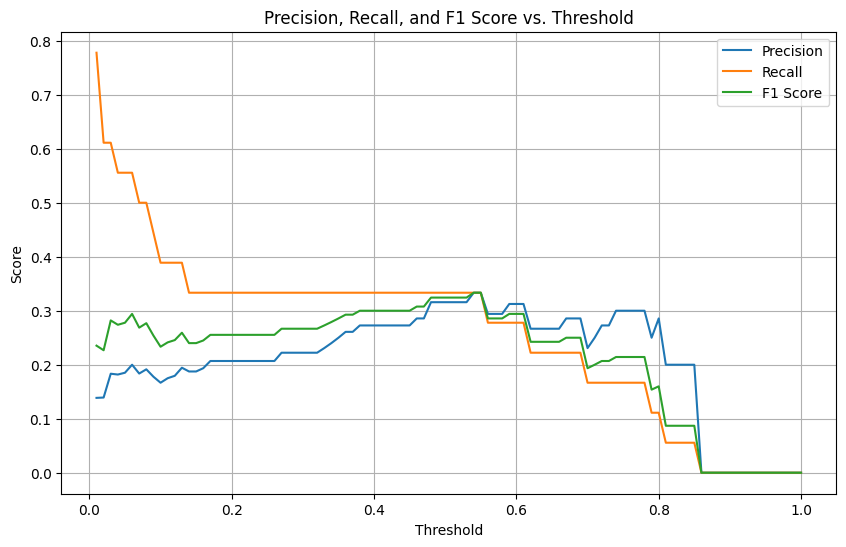

In [ ]:
# Cell 3: Threshold Sweep Analysis
thresholds = np.linspace(0.01, 1, 100)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.savefig("../results/radial_threshold.png")
plt.show()


## ROC Curve

The ROC curve shows the tradeoff between sensitivity and specificity for the RBF SVM model. The area under the curve (AUC) provides a summary measure of discrimination.


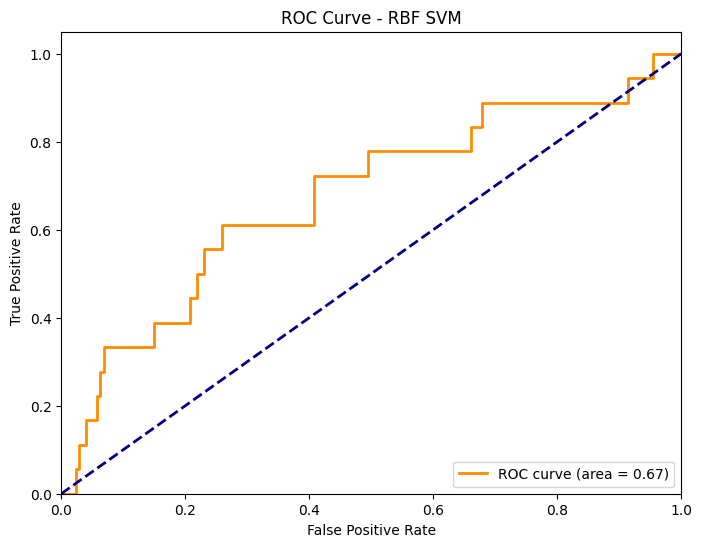

In [ ]:
# Cell 4: ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RBF SVM')
plt.legend(loc="lower right")
plt.savefig("../results/radial_roc.png")
plt.show()


## RBF SVM Decision Boundary with BMI and Age

This plot visualizes the decision boundary learned by the RBF SVM using standardized BMI and Age as predictors. The boundary is flexible and adapts to the data, but recall and precision for diabetes cases are still limited.


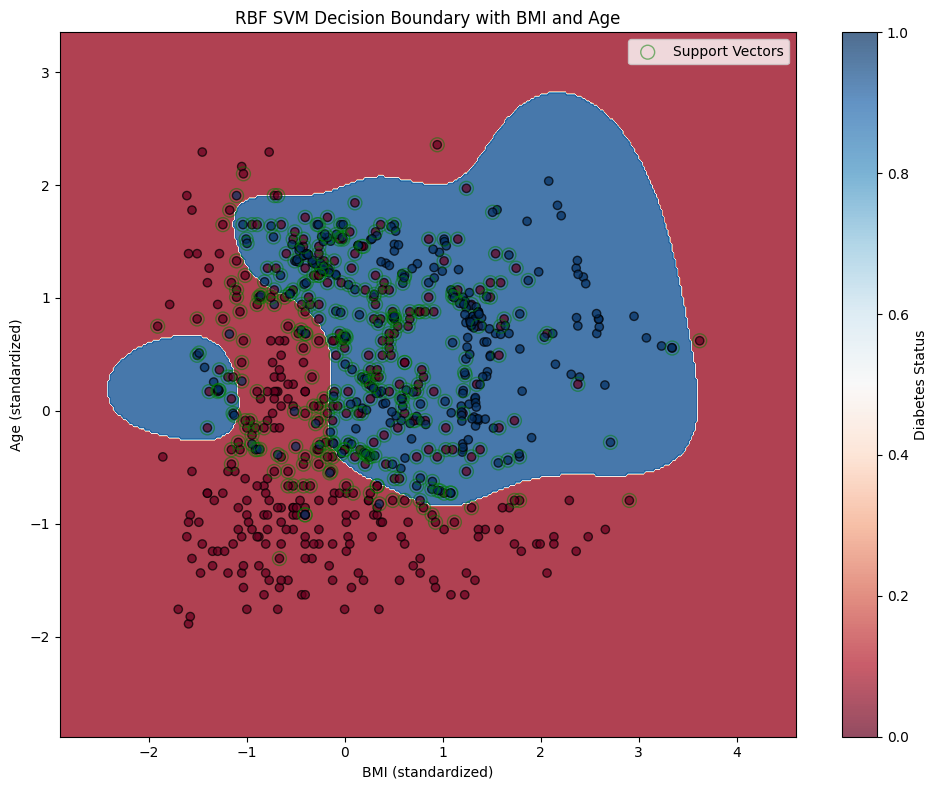

In [ ]:
# Cell 5: Decision Boundary Plot 
idx_bmi = features_with_interaction.index('BMICALC')
idx_age = features_with_interaction.index('AGE')
X_vis = X_train_res[:, [idx_bmi, idx_age]]

svm_viz = SVC(kernel='rbf', 
              C=svm_rbf.best_params_['C'],
              gamma=svm_rbf.best_params_['gamma'],
              class_weight=svm_rbf.best_params_['class_weight'],
              probability=True)
svm_viz.fit(X_vis, y_train_res)

x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='RdBu')
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train_res, edgecolors='k', cmap='RdBu', alpha=0.7)
plt.xlabel('BMI (standardized)')
plt.ylabel('Age (standardized)')
plt.title('RBF SVM Decision Boundary with BMI and Age')
plt.colorbar(scatter, label='Diabetes Status')
sv_indices = svm_viz.support_
plt.scatter(X_vis[sv_indices, 0], X_vis[sv_indices, 1], s=100, linewidth=1, facecolors='none', edgecolors='green', alpha=0.5, label='Support Vectors')
plt.legend()
plt.tight_layout()
plt.savefig("../results/radial_svm.png")
plt.show()


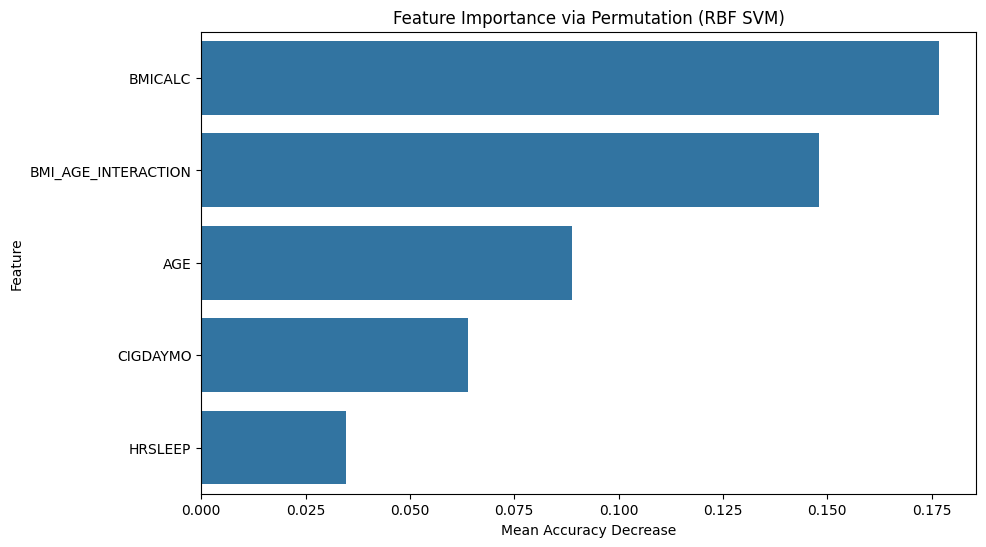

Key Findings:
Most Important Feature: BMICALC
Least Important Feature: HRSLEEP


In [ ]:

from sklearn.inspection import permutation_importance
result = permutation_importance(
    svm_rbf,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)


feature_names = features_with_interaction
importances = result.importances_mean

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance via Permutation (RBF SVM)')
plt.xlabel('Mean Accuracy Decrease')
plt.ylabel('Feature')
plt.savefig("../results/radial_feature_importance.png")
plt.show()

print("Key Findings:")
print(f"Most Important Feature: {importance_df.iloc[0]['Feature']}")
print(f"Least Important Feature: {importance_df.iloc[-1]['Feature']}")


## Conclusion: RBF Kernel SVM for Diabetes Prediction

### Key Findings
- **Test Accuracy:** 83.85% (highest among tested kernels)  
- **Diabetes Recall:** 33% (detects 6/18 diabetes cases)  
- **Diabetes Precision:** 24% (19 false positives)  
- **AUC:** 0.65 (modest discrimination ability)  

### Clinical Implications  
- **Strengths:**  
  - Best overall accuracy (84%)  
  - Fewest false positives (19 vs. 64 in linear SVM)  
  - Flexible decision boundary adapts to local patterns  
- **Limitations:**  
  - Misses 12/18 diabetes cases (critical for screening)  
  - Low precision means 76% of "diabetes" predictions are false alarms  
  - ROC performance (AUC=0.65) barely exceeds random guessing  

### Threshold Analysis  
The threshold sweep plot shows:  
- Recall peaks at ~90% for thresholds <0.2, but precision plummets to <10%  
- At default threshold (0.5), recall/precision are balanced but clinically inadequate  

### Recommendation  
While the RBF kernel achieves the highest accuracy, its poor recall for diabetes (33%) makes it unsuitable for screening. The linear SVM (recall=78%) remains preferable despite lower accuracy.

**Final Verdict:**  
The RBF kernel's flexibility does not translate to clinically meaningful diabetes detection improvements in this dataset. Prioritize linear SVM for screening.
